# Retrieval-Augmented Generation: Question Answering based on Custom Dataset with Open-sourced [LangChain](https://python.langchain.com/en/latest/index.html) Library



Many use cases such as building a chatbot require text (text2text) generation models like **[BloomZ 7B1](https://huggingface.co/bigscience/bloomz-7b1)**, **[Flan T5 XXL](https://huggingface.co/google/flan-t5-xxl)**, and **[Flan T5 UL2](https://huggingface.co/google/flan-ul2)** to respond to user questions with insightful answers. The **BloomZ 7B1**, **Flan T5 XXL**, and **Flan T5 UL2** models have picked up a lot of general knowledge in training, but we often need to ingest and use a large library of more specific information.

In this notebook we will demonstrate how to use  **Flan T5 XXL** to answer questions using a library of documents as a reference, by using document embeddings and retrieval. The embeddings are generated from **GPT-J-6B** embedding model. 

**This notebook serves a template such that you can easily replace the example dataset by your own to build a custom question and answering application.**

## Step 1. Deploy large language model (LLM) and embedding model in SageMaker JumpStart

To better illustrate the idea, let's first deploy the models that are required to perform the demo.

In [2]:
%pip install faiss-cpu==1.7.4 --quiet


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install langchain==0.0.222 --quiet


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import time,datetime
import sagemaker, boto3, json
from sagemaker.session import Session
from sagemaker.model import Model
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base
from typing import Any, Dict, List, Optional
from langchain.embeddings import SagemakerEndpointEmbeddings
from langchain.llms.sagemaker_endpoint import ContentHandlerBase

sagemaker_session = Session()
aws_region = boto3.Session().region_name
model_version = "*"

In [5]:
# Define a couple of auxially functions to wrap the request to the LLM endpoint and its response

def query_endpoint_with_json_payload(encoded_json, endpoint_name, content_type="application/json"):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_json
    )
    return response


def parse_response_model_flan_t5(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    generated_text = model_predictions["generated_texts"]
    return generated_text


In [6]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"
from sagemaker.jumpstart.model import JumpStartModel
from sagemaker.utils import name_from_base
import json
from datetime import datetime

In [7]:
LLM_CONFIG = {
    'model_id': "huggingface-text2text-flan-t5-xxl-bnb-int8",
    'endpoint_name': 'flan-t5-xxl-llm',
    "parse_function": parse_response_model_flan_t5,
    "prompt": """Answer based on context:\n\n{context}\n\n{question}""",
}

EMBEDDINGS_CONFIG = {
    'model_id': "huggingface-textembedding-gpt-j-6b-fp16",
    'endpoint_name': 'gpt-j-6b-embeddings',

}

In [8]:
# Deploy the LLM 

model = JumpStartModel(model_id=LLM_CONFIG['model_id']) 
LLM_CONFIG['model_name'] = model.name
llm_endpoint_name = LLM_CONFIG["endpoint_name"]

print(model)
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S") + " Starting model deployment. This takes around 6 minutes.")

model.deploy(endpoint_name=llm_endpoint_name)

print(f"\n{bold}Model {LLM_CONFIG['model_id']} has been deployed successfully.{unbold}{newline}")
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S  ") + "Completed model deployment.")

JumpStartModel: {'model_id': 'huggingface-text2text-flan-t5-xxl-bnb-int8', 'model_version': '*', 'instance_type': 'ml.g5.2xlarge', 'tolerate_vulnerable_model': False, 'tolerate_deprecated_model': False, 'region': 'us-east-1', 'model_data': 's3://jumpstart-cache-prod-us-east-1/huggingface-infer/prepack/v1.1.2/infer-prepack-huggingface-text2text-flan-t5-xxl-bnb-int8.tar.gz', 'image_uri': '763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.13.1-transformers4.26.0-gpu-py39-cu117-ubuntu20.04', 'predictor_cls': <class 'sagemaker.base_predictor.Predictor'>, 'name': 'hf-text2text-flan-t5-xxl-bnb-int8-2023-10-19-17-56-21-628', 'sagemaker_session': <sagemaker.session.Session object at 0x7f16449629b0>, 'role': 'arn:aws:iam::404275508531:role/sm-e2e-SageMakerExecutionRole-1H4UNcewTNuR', '_is_compiled_model': False, '_is_edge_packaged_model': False, '_enable_network_isolation': True, 'env': {'SAGEMAKER_PROGRAM': 'inference.py', 'ENDPOINT_SERVER_TIMEOUT': '3600', 'MODEL_CAC

In [11]:
# Deploy the Embeddings model 

model = JumpStartModel(model_id=EMBEDDINGS_CONFIG['model_id'],instance_type='ml.p3.2xlarge') 
EMBEDDINGS_CONFIG['model_name'] = model.name

print(model)
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "Starting model deployment. This takes around 6 minutes.")

model.deploy(endpoint_name=EMBEDDINGS_CONFIG['endpoint_name'])

print(f"\n{bold}Model {EMBEDDINGS_CONFIG['model_id']} has been deployed successfully.{unbold}{newline}")
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S  ") + "Completed model deployment.")

JumpStartModel: {'model_id': 'huggingface-textembedding-gpt-j-6b-fp16', 'model_version': '*', 'instance_type': 'ml.p3.2xlarge', 'tolerate_vulnerable_model': False, 'tolerate_deprecated_model': False, 'region': 'us-east-1', 'model_data': 's3://jumpstart-cache-prod-us-east-1/huggingface-infer/prepack/v1.0.1/infer-prepack-huggingface-textembedding-gpt-j-6b-fp16.tar.gz', 'image_uri': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.12.0-gpu-py38', 'predictor_cls': <class 'sagemaker.base_predictor.Predictor'>, 'name': 'hf-textembedding-gpt-j-6b-fp16-2023-10-19-18-16-03-666', 'sagemaker_session': <sagemaker.session.Session object at 0x7f16906b7f40>, 'role': 'arn:aws:iam::404275508531:role/sm-e2e-SageMakerExecutionRole-1H4UNcewTNuR', '_is_compiled_model': False, '_is_edge_packaged_model': False, '_enable_network_isolation': True, 'env': {'SAGEMAKER_PROGRAM': 'inference.py', 'ENDPOINT_SERVER_TIMEOUT': '3600', 'MODEL_CACHE_ROOT': '/opt/ml/model', 'SAGEMAKER_ENV': '1', 'TS_DEFAU

## Step 2. Ask a question to LLM without providing the context

To better illustrate why we need retrieval-augmented generation (RAG) based approach to solve the question and anwering problem. Let's directly ask the model a question and see how they respond.

In [13]:
question = "Which instances can I use with Managed Spot Training in SageMaker?"

In [14]:
payload = {
    "text_inputs": question,
    "max_length": 100,
    "num_return_sequences": 1,
    "top_p": 0.75,
    "do_sample": True
}

query_response = query_endpoint_with_json_payload(
    json.dumps(payload).encode("utf-8"), endpoint_name=llm_endpoint_name
)
generated_texts = LLM_CONFIG["parse_function"](query_response)

print(f"The question: {bold}{payload['text_inputs']}{unbold}{newline}")
print(f"The generated output is: {bold}{generated_texts[0]}{unbold}{newline}")

The question: Which instances can I use with Managed Spot Training in SageMaker?

The generated output is: SageMaker Server



You can see the generated answer is wrong or doesn't make much sense. 

## Step 3. Improve the answer to the same question using **prompt engineering** with insightful context


To better answer the question well, we provide extra contextual information, combine it with a prompt, and send it to model together with the question. Below is an example.

In [15]:
context = """Managed Spot Training can be used with all instances supported in Amazon SageMaker. Managed Spot Training is supported in all AWS Regions where Amazon SageMaker is currently available."""

In [16]:
parameters = {
    "max_length": 200,
    "num_return_sequences": 1,
    "top_p": 0.75,
    "do_sample": True,
    "temperature": 0.3
}

prompt = LLM_CONFIG["prompt"]

text_input = prompt.replace("{context}", context)
text_input = text_input.replace("{question}", question)
payload = {"text_inputs": text_input, **parameters}

query_response = query_endpoint_with_json_payload(
    json.dumps(payload).encode("utf-8"), endpoint_name=llm_endpoint_name
)
generated_texts = LLM_CONFIG["parse_function"](query_response)

print(f"The question: {bold}{question}{unbold}{newline}")
print(f"The generated output is: {bold}{generated_texts[0]}{unbold}{newline}")

The question: Which instances can I use with Managed Spot Training in SageMaker?

The generated output is: all instances supported in Amazon SageMaker



The output from step 3 tells us the chance to get the correct response significantly correlates with the insightful context you send into the LLM. 

**<span style="color:red">Now, the question becomes where can I find the insightful context based on the user query? The answer is to use a pre-stored knowledge data base with retrieval augmented generation, as shown in step 4 below</span>.**

## Step 4. Use RAG based approach with [LangChain](https://python.langchain.com/en/latest/index.html) and SageMaker endpoints to build a simplified question and answering application.


We plan to use document embeddings to fetch the most relevant documents in our document knowledge library and combine them with the prompt that we provide to LLM.

To achieve that, we will do following.

1. **Generate embedings for each of document in the knowledge library with SageMaker GPT-J-6B embedding model.**
2. **Identify top K most relevant documents based on user query.**
    - 2.1 **For a query of your interest, generate the embedding of the query using the same embedding model.**
    - 2.2 **Search the indexes of top K most relevant documents in the embedding space using in-memory Faiss search.**
    - 2.3 **Use the indexes to retrieve the corresponding documents.**
3. **Combine the retrieved documents with prompt and question and send them into SageMaker LLM.**



Note: The retrieved document/text should be large enough to contain enough information to answer a question; but small enough to fit into the LLM prompt -- maximum sequence length of 1024 tokens. 

---
To build a simiplied Question and Answer application with LangChain, we will: 
1. Wrap the SageMaker endpoints for embedding model and LLM into `langchain.embeddings.SagemakerEndpointEmbeddings` and `langchain.llms.sagemaker_endpoint.SagemakerEndpoint`. That requires an edit/overwrite of the `SagemakerEndpointEmbeddings` class to make it compatible with the specific embedding model that is being used.
2. Prepare the dataset to build the knowledge data base. 
---

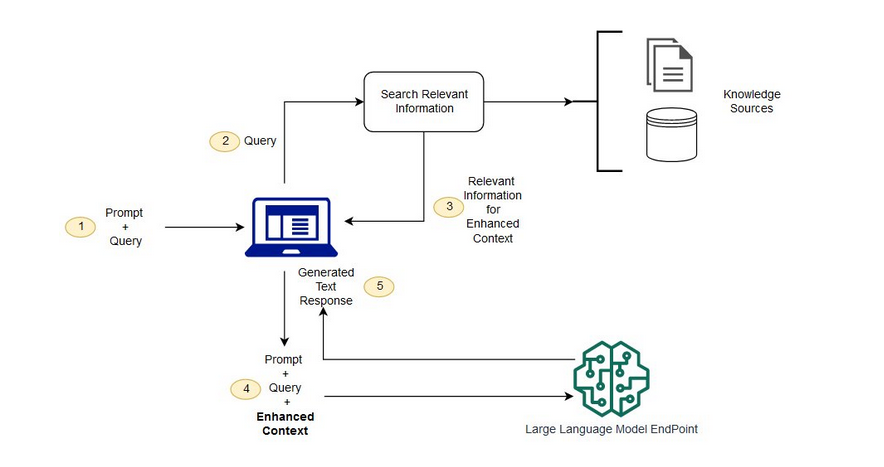


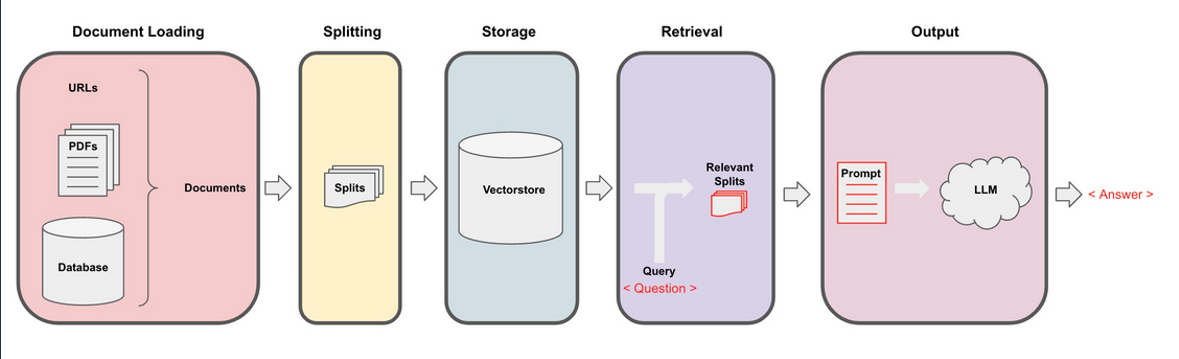


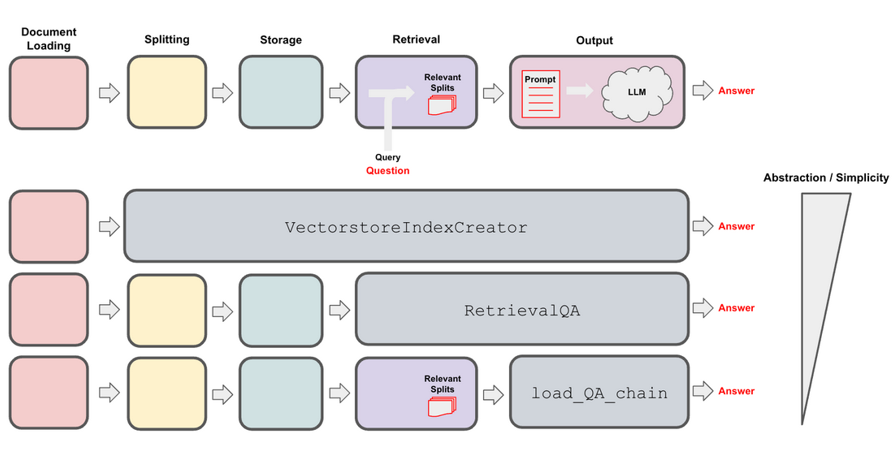

In [17]:
from langchain.embeddings.sagemaker_endpoint import EmbeddingsContentHandler


class SagemakerEndpointEmbeddingsJumpStart(SagemakerEndpointEmbeddings):
    def embed_documents(self, texts: List[str], chunk_size: int = 5) -> List[List[float]]:
        """Compute doc embeddings using a SageMaker Inference Endpoint.

        Args:
            texts: The list of texts to embed.
            chunk_size: The chunk size defines how many input texts will
                be grouped together as request. If None, will use the
                chunk size specified by the class.

        Returns:
            List of embeddings, one for each text.
        """
        results = []
        _chunk_size = len(texts) if chunk_size > len(texts) else chunk_size

        for i in range(0, len(texts), _chunk_size):
            response = self._embedding_func(texts[i : i + _chunk_size])
            print
            results.extend(response)
        return results


class ContentHandler(EmbeddingsContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"text_inputs": prompt, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        embeddings = response_json["embedding"]
        return embeddings


content_handler = ContentHandler()

embeddings = SagemakerEndpointEmbeddingsJumpStart(
    endpoint_name=EMBEDDINGS_CONFIG["endpoint_name"],
    region_name=aws_region,
    content_handler=content_handler,
)

Next, we wrap up our SageMaker endpoints for LLM into `langchain.llms.sagemaker_endpoint.SagemakerEndpoint`. 

In [18]:
from langchain.llms.sagemaker_endpoint import LLMContentHandler, SagemakerEndpoint

parameters = {
    "max_length": 200,
    "num_return_sequences": 1,
    "top_p": 0.75,
    "do_sample": True,
    "temperature": 0.3,
}


class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"text_inputs": prompt, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["generated_texts"][0]


content_handler = ContentHandler()

sm_llm = SagemakerEndpoint(
    endpoint_name=llm_endpoint_name,
    region_name=aws_region,
    model_kwargs=parameters,
    content_handler=content_handler,
)

Now, let's download the example data and prepare it for demonstration. We will use [Amazon SageMaker FAQs](https://aws.amazon.com/sagemaker/faqs/) as knowledge library. The data are formatted in a CSV file with two columns Question and Answer. We use the Answer column as the documents of knowledge library, from which relevant documents are retrieved based on a query. 

**For your purpose, you can replace the example dataset of your own to build a custom question and answering application.**

In [2]:
original_data = "s3://jumpstart-cache-prod-us-east-2/training-datasets/Amazon_SageMaker_FAQs/"

!mkdir -p rag_data
!aws s3 cp --recursive $original_data rag_data

download: s3://jumpstart-cache-prod-us-east-2/training-datasets/Amazon_SageMaker_FAQs/Amazon_SageMaker_FAQs.csv to rag_data/Amazon_SageMaker_FAQs.csv


For the case when you have data saved in multiple subsets. The following code will read all files that end with `.csv` and concatenate them together. Please ensure each `csv` file has the same format.

In [20]:
import glob
import os
import pandas as pd

all_files = glob.glob(os.path.join("rag_data/", "*.csv"))

df_knowledge = pd.concat(
    (pd.read_csv(f, header=None, names=["Question", "Answer"]) for f in all_files),
    axis=0,
    ignore_index=True,
)

Drop the `Question` column as it is not used in this demonstration.

In [21]:
df_knowledge.drop(["Question"], axis=1, inplace=True)

In [22]:
df_knowledge.head(5)

,Answer
0,Amazon SageMaker is a fully managed service to...
1,For a list of the supported Amazon SageMaker A...
2,Amazon SageMaker is designed for high availabi...
3,Amazon SageMaker stores code in ML storage vol...
4,Amazon SageMaker ensures that ML model artifac...


In [23]:
df_knowledge.to_csv("rag_data/processed_data.csv", header=False, index=False)

In [24]:
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.document_loaders import TextLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import Chroma, AtlasDB, FAISS
from langchain.text_splitter import CharacterTextSplitter
from langchain import PromptTemplate
from langchain.chains.question_answering import load_qa_chain
from langchain.document_loaders.csv_loader import CSVLoader

Use langchain to read the `csv` data. There are multiple built-in functions in LangChain to read different format of files such as `txt`, `html`, and `pdf`. For details, see [LangChain document loaders](https://python.langchain.com/en/latest/modules/indexes/document_loaders.html).

In [25]:
loader = CSVLoader(file_path="rag_data/processed_data.csv")

In [26]:
documents = loader.load()
# text_splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0)
# texts = text_splitter.split_documents(documents) ### if you use langchain.document_loaders.TextLoader to load text file. You can uncomment the code
## to split the text.

**Now, we can build an QA application. <span style="color:red">LangChain makes it extremly simple with following few lines of code</span>.**

Based on the question below, we can achieven the points in Step 4 with just a few lines of code as shown below.

In [27]:
index_creator = VectorstoreIndexCreator(
    vectorstore_cls=FAISS,
    embedding=embeddings,
    text_splitter=CharacterTextSplitter(chunk_size=300, chunk_overlap=0),
)
#index_creator

In [28]:
# Create the index and populate it with the chunked document data

index = index_creator.from_loaders([loader])

In [29]:
# We will use the same question as before

question = "Which instances can I use with Managed Spot Training in SageMaker?"

In [30]:
# Query the index with our example question

index.query(question=question, llm=sm_llm)

'Amazon EC2 Spot instances'

In [31]:
#index.query_with_sources(query)
#It can also be convenient to filter the vector store by the metadata associated with documents, particularly when your vector store has multiple sources. This can be done using the query method like so:
#index.query("Summarize the general content of this document.", retriever_kwargs={"search_kwargs": {"filter": {"source": "../state_of_the_union.txt"}}})

index.vectorstore


In [32]:
index.vectorstore.as_retriever()

VectorStoreRetriever(vectorstore=<langchain.vectorstores.faiss.FAISS object at 0x7f1640ff1780>, search_type='similarity', search_kwargs={})

In [33]:
index_creator.embedding

SagemakerEndpointEmbeddingsJumpStart(client=<botocore.client.SageMakerRuntime object at 0x7f1642ccaad0>, endpoint_name='gpt-j-6b-embeddings', region_name='us-east-1', credentials_profile_name=None, content_handler=<__main__.ContentHandler object at 0x7f1642cc82b0>, model_kwargs=None, endpoint_kwargs=None)

## Step 5. Customize the Question and Answer application above with different prompt.

Now, we see how simple it is to use LangChain to achieve question and answering application with just few lines of code. Let's break down the above `VectorstoreIndexCreator` and see what's happening under the hood. Furthermore, we will see how to incorporate a customize prompt rather than using a default prompt with `VectorstoreIndexCreator`.

Firstly, we generate embedings for each of document in the knowledge library with SageMaker GPT-J-6B embedding model.

In [ ]:
docsearch = FAISS.from_documents(documents, embeddings)

In [ ]:
question

In [ ]:
docs = docsearch.similarity_search(question, k=3)

In [ ]:
docs

In [ ]:
prompt_template = """Answer based on context:\n\n{context}\n\n{question}"""

PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

print(PROMPT)

In [ ]:
chain = load_qa_chain(llm=sm_llm, prompt=PROMPT)

In [ ]:
result = chain({"input_documents": docs, "question": question}, return_only_outputs=True)[
    "output_text"
]

In [ ]:
print(f"The question: {bold}{question}{unbold}{newline}")
print(f"The generated output is: {bold}{result}{unbold}{newline}")

In [ ]:
# Let's try a different question

question = "What is sagemaker?"

docs = docsearch.similarity_search(question, k=3)

result = chain({"input_documents": docs, "question": question}, return_only_outputs=True)[
    "output_text"
]

In [ ]:
print(f"The question: {bold}{question}{unbold}{newline}")
print(f"The generated output is: {bold}{result}{unbold}{newline}")

## Step 6: Clean up 

In [ ]:
# Change False to True and re-run this cell when you are finished with the lab and/or want to delete your endpoints
if False:
# if True:
    for config in (LLM_CONFIG, EMBEDDINGS_CONFIG):
        model_name=config["model_name"]
        endpoint_name=config["endpoint_name"]
        client=boto3.client("sagemaker")
        client.delete_model(ModelName=model_name)   
        client.delete_endpoint_config(EndpointConfigName=endpoint_name)
        client.delete_endpoint(EndpointName=endpoint_name)
        print("Deleted Model " + model_name + "\nEndpoint "  + endpoint_name)
